In [1]:
%pip install openmeteo-requests requests_cache pandas python-dotenv retry-requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.7/685.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 84.5 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 25.12.19
    Uninstalling flatbuffers-25.12.19:
      Successfully uninstalled flatbuffers-25.12.19


In [2]:
import sys
import os
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from dotenv import load_dotenv
from datetime import datetime, timedelta

In [3]:
LAT=24.8608
LON=67.0104

def fetch_historical_data(start_date, end_date):
    """
    Fetches historical weather and AQI data from Open-Meteo
    """
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # Weather API
    weather_url = "https://archive-api.open-meteo.com/v1/archive"
    weather_params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["temperature_2m", "relative_humidity_2m", "pressure_msl", "surface_pressure", "wind_speed_10m", "wind_direction_10m", "cloud_cover"]
    }
    
    # AQI API (Air Quality)
    aqi_url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    aqi_params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["pm10", "pm2_5", "carbon_monoxide", "nitrogen_dioxide", "sulphur_dioxide", "ozone", "ammonia", "us_aqi"]
    }

    print(f"Fetching historical data from {start_date} to {end_date}...")
    
    try:
        weather_responses = openmeteo.weather_api(weather_url, params=weather_params)
        aqi_responses = openmeteo.weather_api(aqi_url, params=aqi_params)
    except Exception as e:
        print(f"Error calling Open-Meteo API: {e}")
        return pd.DataFrame() # Return empty on error to avoid crash

    # Process Weather Data
    if not weather_responses:
         print("No weather data returned.")
         return pd.DataFrame()

    response = weather_responses[0]
    hourly = response.Hourly()
    print(f"Weather data points: {hourly.Variables(0).ValuesAsNumpy().size}")
    
    hourly_data = {"datetime": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}
    
    weather_data = {
        "datetime": hourly_data["datetime"],
        "temp": hourly.Variables(0).ValuesAsNumpy(),
        "humidity": hourly.Variables(1).ValuesAsNumpy(),
        "pressure": hourly.Variables(2).ValuesAsNumpy(),
        "wind_speed": hourly.Variables(4).ValuesAsNumpy(),
        "wind_deg": hourly.Variables(5).ValuesAsNumpy(),
        "clouds": hourly.Variables(6).ValuesAsNumpy()
    }
    weather_df = pd.DataFrame(data = weather_data)

    # Process AQI Data
    response = aqi_responses[0]
    hourly = response.Hourly()
    
    hourly_data = {"datetime": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}
    
    aqi_data = {
        "datetime": hourly_data["datetime"],
        "pm10": hourly.Variables(0).ValuesAsNumpy(),
        "pm2_5": hourly.Variables(1).ValuesAsNumpy(),
        "co": hourly.Variables(2).ValuesAsNumpy(),
        "no2": hourly.Variables(3).ValuesAsNumpy(),
        "so2": hourly.Variables(4).ValuesAsNumpy(),
        "o3": hourly.Variables(5).ValuesAsNumpy(),
        "nh3": hourly.Variables(6).ValuesAsNumpy(),
        "aqi": hourly.Variables(7).ValuesAsNumpy(), # US AQI
    }
    aqi_df = pd.DataFrame(data = aqi_data)

    # Merge DataFrames
    print("Weather DF Head:")
    print(weather_df.head())
    print("AQI DF Head:")
    print(aqi_df.head())
    
    merged_df = pd.merge(weather_df, aqi_df, on="datetime")
    
    # Handle missing values
    print("Missing values before filling:")
    print(merged_df.isna().sum())
    
    merged_df = merged_df.ffill().bfill().fillna(0)
    
    
    return merged_df


In [4]:
df=fetch_historical_data("2025-08-01",datetime.now().strftime("%Y-%m-%d"))

Fetching historical data from 2025-08-01 to 2026-02-17...
Weather data points: 4824
Weather DF Head:
                   datetime       temp   humidity     pressure  wind_speed  \
0 2025-08-01 00:00:00+00:00  26.549999  90.678726  1000.200012   10.134496   
1 2025-08-01 01:00:00+00:00  27.000000  91.792793   999.900024   10.985900   
2 2025-08-01 02:00:00+00:00  27.400000  88.604935  1000.799988   13.272482   
3 2025-08-01 03:00:00+00:00  28.549999  75.067810  1001.299988   14.169785   
4 2025-08-01 04:00:00+00:00  29.000000  73.134613  1001.599976   13.878689   

     wind_deg  clouds  
0  250.277634    95.0  
1  251.861816    75.0  
2  249.352936    23.0  
3  244.411530    47.0  
4  236.103790    99.0  
AQI DF Head:
                   datetime       pm10      pm2_5     co  no2   so2    o3  \
0 2025-08-01 00:00:00+00:00  45.799999  19.700001  174.0  8.4   8.7  45.0   
1 2025-08-01 01:00:00+00:00  45.200001  19.299999  217.0  9.0   9.4  46.0   
2 2025-08-01 02:00:00+00:00  51.000000  20

In [5]:
df.head()

datetime       temp   humidity     pressure  wind_speed  \
0 2025-08-01 00:00:00+00:00  26.549999  90.678726  1000.200012   10.134496   
1 2025-08-01 01:00:00+00:00  27.000000  91.792793   999.900024   10.985900   
2 2025-08-01 02:00:00+00:00  27.400000  88.604935  1000.799988   13.272482   
3 2025-08-01 03:00:00+00:00  28.549999  75.067810  1001.299988   14.169785   
4 2025-08-01 04:00:00+00:00  29.000000  73.134613  1001.599976   13.878689   

     wind_deg  clouds       pm10      pm2_5     co  no2   so2    o3  nh3  \
0  250.277634    95.0  45.799999  19.700001  174.0  8.4   8.7  45.0  0.0   
1  251.861816    75.0  45.200001  19.299999  217.0  9.0   9.4  46.0  0.0   
2  249.352936    23.0  51.000000  20.299999  277.0  9.8  10.4  48.0  0.0   
3  244.411530    47.0  54.099998  20.500000  312.0  9.9  11.3  51.0  0.0   
4  236.103790    99.0  64.699997  21.799999  295.0  8.6  12.0  58.0  0.0   

         aqi  
0  80.815605  
1  80.310287  
2  79.804970  
3  79.255325  
4  78.625893

In [6]:
df.tail()

datetime       temp   humidity     pressure  wind_speed  \
4819 2026-02-17 19:00:00+00:00  20.549999  73.504898  1013.599976    5.717657   
4820 2026-02-17 20:00:00+00:00  19.799999  67.017136  1013.299988    6.287130   
4821 2026-02-17 21:00:00+00:00  19.299999  64.546577  1013.299988    7.657937   
4822 2026-02-17 22:00:00+00:00  18.900000  64.671585  1012.900024    7.841887   
4823 2026-02-17 23:00:00+00:00  18.549999  65.452576  1013.099976    8.085988   

       wind_deg  clouds       pm10      pm2_5     co        no2        so2  \
4819  28.178495     0.0  52.400002  37.099998  883.0  42.000000  19.700001   
4820  23.629398     0.0  51.599998  35.700001  563.0  25.700001  17.299999   
4821  23.552286     0.0  48.299999  32.200001  335.0  13.000000  15.300000   
4822  31.865936     0.0  46.200001  28.700001  265.0   7.300000  13.900000   
4823  16.821489     0.0  45.500000  26.400000  288.0   5.200000  12.800000   

        o3  nh3        aqi  
4819  49.0  0.0  88.909569  
4820  72.0  0.0  89.716301  
4821  89.0  0.0  90.585098  
4822  95.0  0.0  91.400703  
4823  96.0  0.0  92.039009

In [7]:
df.shape

(4824, 15)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4824 entries, 0 to 4823
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   datetime    4824 non-null   datetime64[ns, UTC]
 1   temp        4824 non-null   float32            
 2   humidity    4824 non-null   float32            
 3   pressure    4824 non-null   float32            
 4   wind_speed  4824 non-null   float32            
 5   wind_deg    4824 non-null   float32            
 6   clouds      4824 non-null   float32            
 7   pm10        4824 non-null   float32            
 8   pm2_5       4824 non-null   float32            
 9   co          4824 non-null   float32            
 10  no2         4824 non-null   float32            
 11  so2         4824 non-null   float32            
 12  o3          4824 non-null   float32            
 13  nh3         4824 non-null   float32            
 14  aqi         4824 non-null   float32     

In [9]:
df.isnull().sum()

datetime      0
temp          0
humidity      0
pressure      0
wind_speed    0
wind_deg      0
clouds        0
pm10          0
pm2_5         0
co            0
no2           0
so2           0
o3            0
nh3           0
aqi           0
dtype: int64

In [10]:
df.describe()

temp     humidity     pressure   wind_speed     wind_deg  \
count  4824.000000  4824.000000  4824.000000  4824.000000  4824.000000   
mean     24.688910    60.673080  1011.738159     9.525787   189.447998   
std       4.925853    23.092094     6.457486     4.213761   112.070290   
min       9.250000     7.474424   997.500000     0.180000     1.145742   
25%      20.850000    41.190183  1006.200012     6.655128    57.994659   
50%      25.850000    63.447392  1013.000000     9.011691   235.280762   
75%      28.000000    81.472778  1017.200012    12.219468   271.273010   
max      40.200001    99.690269  1025.199951    23.828083   360.000000   

            clouds         pm10        pm2_5           co          no2  \
count  4824.000000  4824.000000  4824.000000  4824.000000  4824.000000   
mean     31.399462    49.482563    32.509453   701.173096    27.011917   
std      40.143291    24.923933    14.331616   535.185425    22.960350   
min       0.000000     7.600000     7.000000    74.000000     0.000000   
25%       0.000000    33.400002    22.200001   309.000000     9.200000   
50%       5.000000    45.099998    29.500000   530.000000    19.299999   
75%      71.000000    60.099998    39.700001   946.500000    38.799999   
max     100.000000   262.600006    96.400002  4515.000000   138.500000   

               so2           o3     nh3          aqi  
count  4824.000000  4824.000000  4824.0  4824.000000  
mean     18.601076    68.506218     0.0    95.238342  
std       9.445744    45.223305     0.0    25.207327  
min       4.900000     0.000000     0.0    37.690971  
25%      12.100000    34.000000     0.0    76.781919  
50%      16.000000    57.000000     0.0    90.873230  
75%      22.400000    98.000000     0.0   111.515627  
max      65.400002   195.000000     0.0   160.699554

In [11]:
df_updated=df.drop(columns=['datetime','nh3'],axis=1, inplace=False)

In [12]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4824 entries, 0 to 4823
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        4824 non-null   float32
 1   humidity    4824 non-null   float32
 2   pressure    4824 non-null   float32
 3   wind_speed  4824 non-null   float32
 4   wind_deg    4824 non-null   float32
 5   clouds      4824 non-null   float32
 6   pm10        4824 non-null   float32
 7   pm2_5       4824 non-null   float32
 8   co          4824 non-null   float32
 9   no2         4824 non-null   float32
 10  so2         4824 non-null   float32
 11  o3          4824 non-null   float32
 12  aqi         4824 non-null   float32
dtypes: float32(13)
memory usage: 245.1 KB


In [13]:
df_updated.drop_duplicates()

temp   humidity     pressure  wind_speed    wind_deg  clouds  \
0     26.549999  90.678726  1000.200012   10.134496  250.277634    95.0   
1     27.000000  91.792793   999.900024   10.985900  251.861816    75.0   
2     27.400000  88.604935  1000.799988   13.272482  249.352936    23.0   
3     28.549999  75.067810  1001.299988   14.169785  244.411530    47.0   
4     29.000000  73.134613  1001.599976   13.878689  236.103790    99.0   
...         ...        ...          ...         ...         ...     ...   
4819  20.549999  73.504898  1013.599976    5.717657   28.178495     0.0   
4820  19.799999  67.017136  1013.299988    6.287130   23.629398     0.0   
4821  19.299999  64.546577  1013.299988    7.657937   23.552286     0.0   
4822  18.900000  64.671585  1012.900024    7.841887   31.865936     0.0   
4823  18.549999  65.452576  1013.099976    8.085988   16.821489     0.0   

           pm10      pm2_5     co        no2        so2    o3        aqi  
0     45.799999  19.700001  174.0   8.400000   8.700000  45.0  80.815605  
1     45.200001  19.299999  217.0   9.000000   9.400000  46.0  80.310287  
2     51.000000  20.299999  277.0   9.800000  10.400000  48.0  79.804970  
3     54.099998  20.500000  312.0   9.900000  11.300000  51.0  79.255325  
4     64.699997  21.799999  295.0   8.600000  12.000000  58.0  78.625893  
...         ...        ...    ...        ...        ...   ...        ...  
4819  52.400002  37.099998  883.0  42.000000  19.700001  49.0  88.909569  
4820  51.599998  35.700001  563.0  25.700001  17.299999  72.0  89.716301  
4821  48.299999  32.200001  335.0  13.000000  15.300000  89.0  90.585098  
4822  46.200001  28.700001  265.0   7.300000  13.900000  95.0  91.400703  
4823  45.500000  26.400000  288.0   5.200000  12.800000  96.0  92.039009  

[4824 rows x 13 columns]

In [14]:
df_updated.corr()

temp  humidity  pressure  wind_speed  wind_deg    clouds  \
temp        1.000000 -0.058786 -0.678317    0.327788  0.331995  0.224819   
humidity   -0.058786  1.000000 -0.525205    0.067757  0.418311  0.385551   
pressure   -0.678317 -0.525205  1.000000   -0.424100 -0.408949 -0.492079   
wind_speed  0.327788  0.067757 -0.424100    1.000000  0.065779  0.310755   
wind_deg    0.331995  0.418311 -0.408949    0.065779  1.000000  0.160866   
clouds      0.224819  0.385551 -0.492079    0.310755  0.160866  1.000000   
pm10        0.027013  0.137916 -0.075681   -0.022444  0.149504  0.002191   
pm2_5      -0.359856 -0.140917  0.414151   -0.386647 -0.165140 -0.274189   
co         -0.366887 -0.169301  0.465209   -0.541137 -0.185380 -0.281771   
no2        -0.409576  0.068515  0.329232   -0.466666  0.000769 -0.213066   
so2        -0.055891 -0.402189  0.417938   -0.445560 -0.021791 -0.246239   
o3          0.386065 -0.653040  0.152815    0.099533 -0.099341 -0.143519   
aqi        -0.281662 -0.318752  0.493830   -0.404371 -0.162045 -0.386334   

                pm10     pm2_5        co       no2       so2        o3  \
temp        0.027013 -0.359856 -0.366887 -0.409576 -0.055891  0.386065   
humidity    0.137916 -0.140917 -0.169301  0.068515 -0.402189 -0.653040   
pressure   -0.075681  0.414151  0.465209  0.329232  0.417938  0.152815   
wind_speed -0.022444 -0.386647 -0.541137 -0.466666 -0.445560  0.099533   
wind_deg    0.149504 -0.165140 -0.185380  0.000769 -0.021791 -0.099341   
clouds      0.002191 -0.274189 -0.281771 -0.213066 -0.246239 -0.143519   
pm10        1.000000  0.548535  0.091848  0.158761  0.150624 -0.127359   
pm2_5       0.548535  1.000000  0.590271  0.640300  0.472973 -0.175854   
co          0.091848  0.590271  1.000000  0.694030  0.449319 -0.210070   
no2         0.158761  0.640300  0.694030  1.000000  0.318613 -0.588521   
so2         0.150624  0.472973  0.449319  0.318613  1.000000  0.371477   
o3         -0.127359 -0.175854 -0.210070 -0.588521  0.371477  1.000000   
aqi         0.262131  0.681748  0.405836  0.339664  0.458614  0.167577   

                 aqi  
temp       -0.281662  
humidity   -0.318752  
pressure    0.493830  
wind_speed -0.404371  
wind_deg   -0.162045  
clouds     -0.386334  
pm10        0.262131  
pm2_5       0.681748  
co          0.405836  
no2         0.339664  
so2         0.458614  
o3          0.167577  
aqi         1.000000

---
## 📊 Exploratory Data Analysis — Plots & Statistics
Below we create visualisations and statistical summaries to understand the AQI data for **Karachi (24.86°N, 67.01°E)**.

In [15]:
%pip install matplotlib seaborn numpy

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 150

### 1. AQI Distribution
Histogram + KDE of the US-AQI values to see how air quality is spread.

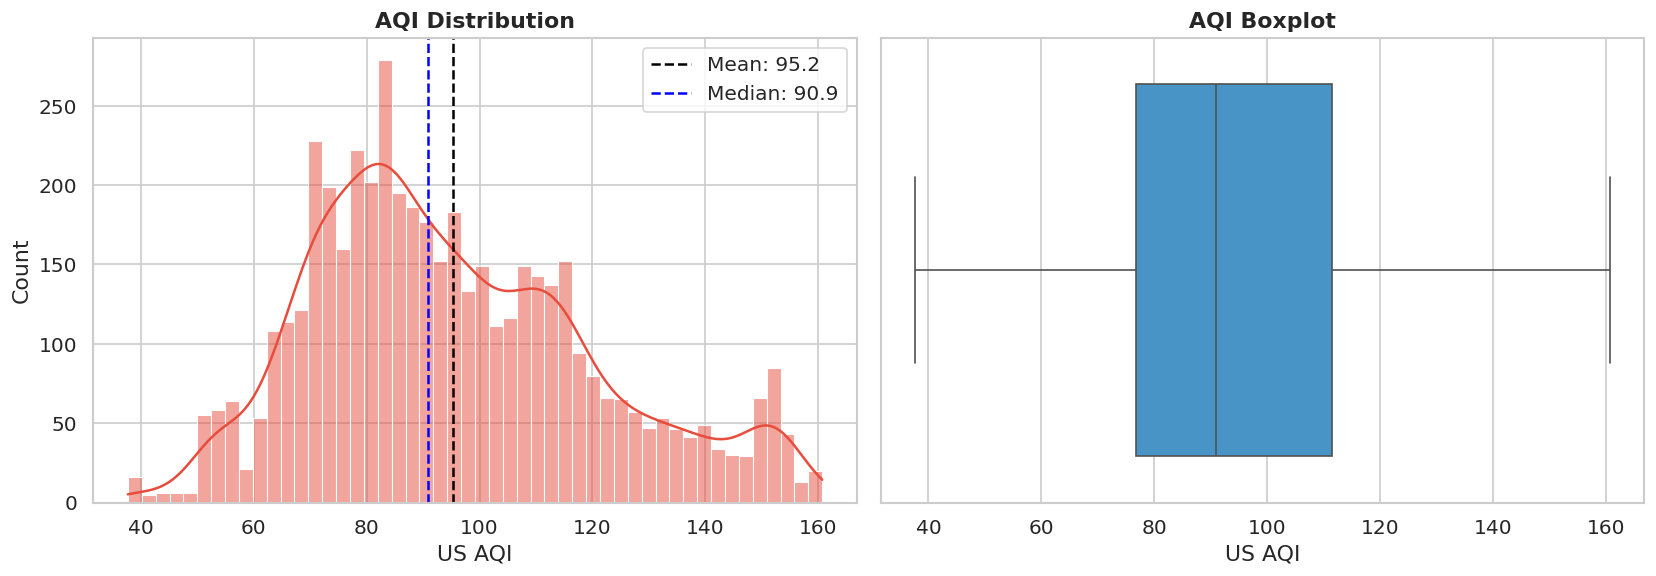

=== AQI Summary Statistics ===
Mean      : 95.24
Median    : 90.87
Std Dev   : 25.21
Skewness  : 0.532
Kurtosis  : -0.246
Min       : 37.69
Max       : 160.70
IQR       : 34.73


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram + KDE
sns.histplot(df['aqi'], bins=50, kde=True, color='#e74c3c', ax=axes[0])
axes[0].set_title('AQI Distribution', fontweight='bold')
axes[0].set_xlabel('US AQI')
axes[0].axvline(df['aqi'].mean(), color='black', ls='--', lw=1.5, label=f"Mean: {df['aqi'].mean():.1f}")
axes[0].axvline(df['aqi'].median(), color='blue', ls='--', lw=1.5, label=f"Median: {df['aqi'].median():.1f}")
axes[0].legend()

# Box plot
sns.boxplot(x=df['aqi'], color='#3498db', ax=axes[1])
axes[1].set_title('AQI Boxplot', fontweight='bold')
axes[1].set_xlabel('US AQI')

plt.tight_layout()
plt.show()

# Print summary stats
print('=== AQI Summary Statistics ===')
print(f"Mean      : {df['aqi'].mean():.2f}")
print(f"Median    : {df['aqi'].median():.2f}")
print(f"Std Dev   : {df['aqi'].std():.2f}")
print(f"Skewness  : {df['aqi'].skew():.3f}")
print(f"Kurtosis  : {df['aqi'].kurtosis():.3f}")
print(f"Min       : {df['aqi'].min():.2f}")
print(f"Max       : {df['aqi'].max():.2f}")
print(f"IQR       : {df['aqi'].quantile(0.75) - df['aqi'].quantile(0.25):.2f}")

### 2. AQI Category Breakdown (US EPA Scale)
Classify each hour into EPA categories and show proportion.

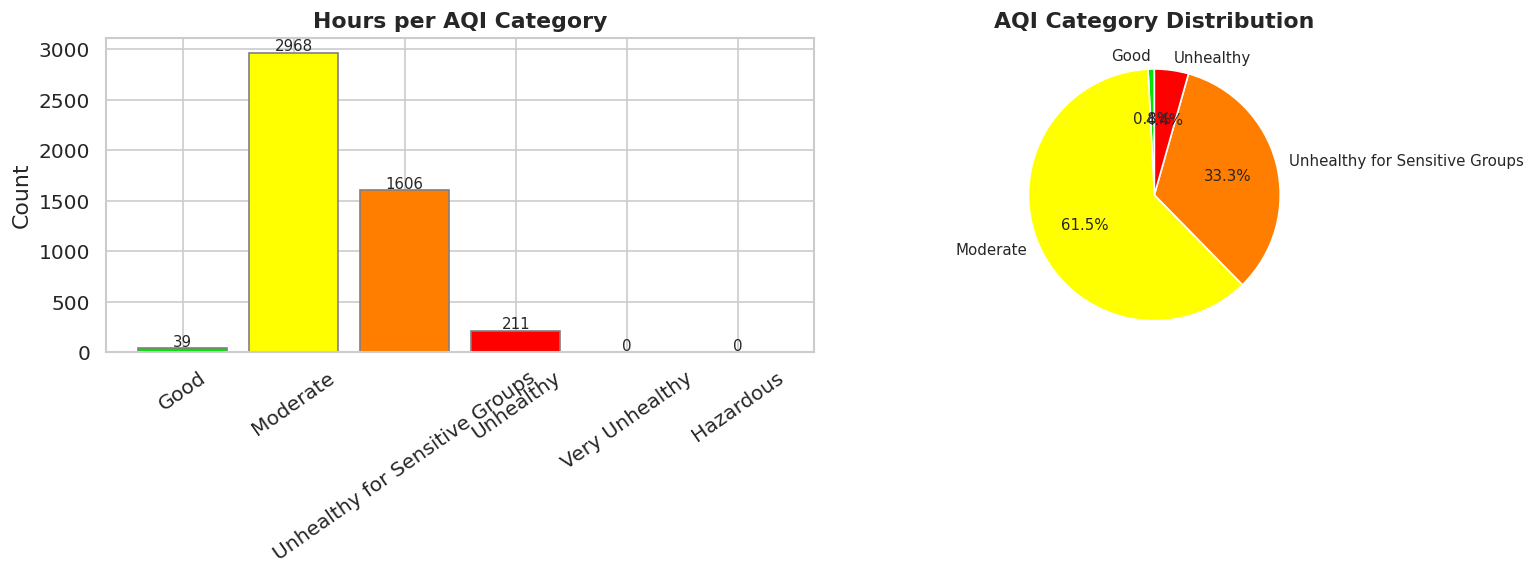


=== Category Counts ===
Good                                        39  (  0.8%)
Moderate                                  2968  ( 61.5%)
Unhealthy for Sensitive Groups            1606  ( 33.3%)
Unhealthy                                  211  (  4.4%)
Very Unhealthy                               0  (  0.0%)
Hazardous                                    0  (  0.0%)


In [18]:
def aqi_category(val):
    if val <= 50:   return 'Good'
    elif val <= 100: return 'Moderate'
    elif val <= 150: return 'Unhealthy for Sensitive Groups'
    elif val <= 200: return 'Unhealthy'
    elif val <= 300: return 'Very Unhealthy'
    else:            return 'Hazardous'

cat_order = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
cat_colors = ['#00e400', '#ffff00', '#ff7e00', '#ff0000', '#8f3f97', '#7e0023']

df['aqi_category'] = df['aqi'].apply(aqi_category)
cat_counts = df['aqi_category'].value_counts().reindex(cat_order).fillna(0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
bars = axes[0].bar(cat_counts.index, cat_counts.values,
                   color=[cat_colors[cat_order.index(c)] for c in cat_counts.index],
                   edgecolor='grey')
axes[0].set_title('Hours per AQI Category', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=35)
for b in bars:
    axes[0].text(b.get_x() + b.get_width()/2, b.get_height() + 20,
                f'{int(b.get_height())}', ha='center', fontsize=9)

# Pie chart
non_zero = cat_counts[cat_counts > 0]
pie_colors = [cat_colors[cat_order.index(c)] for c in non_zero.index]
axes[1].pie(non_zero, labels=non_zero.index, autopct='%1.1f%%',
            colors=pie_colors, startangle=90, textprops={'fontsize': 9})
axes[1].set_title('AQI Category Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

print('\n=== Category Counts ===')
for cat in cat_order:
    cnt = int(cat_counts.get(cat, 0))
    pct = cnt / len(df) * 100
    print(f'{cat:40s} {cnt:5d}  ({pct:5.1f}%)')

### 3. Correlation Heatmap
Visualise pairwise correlations — annotated and color-coded.

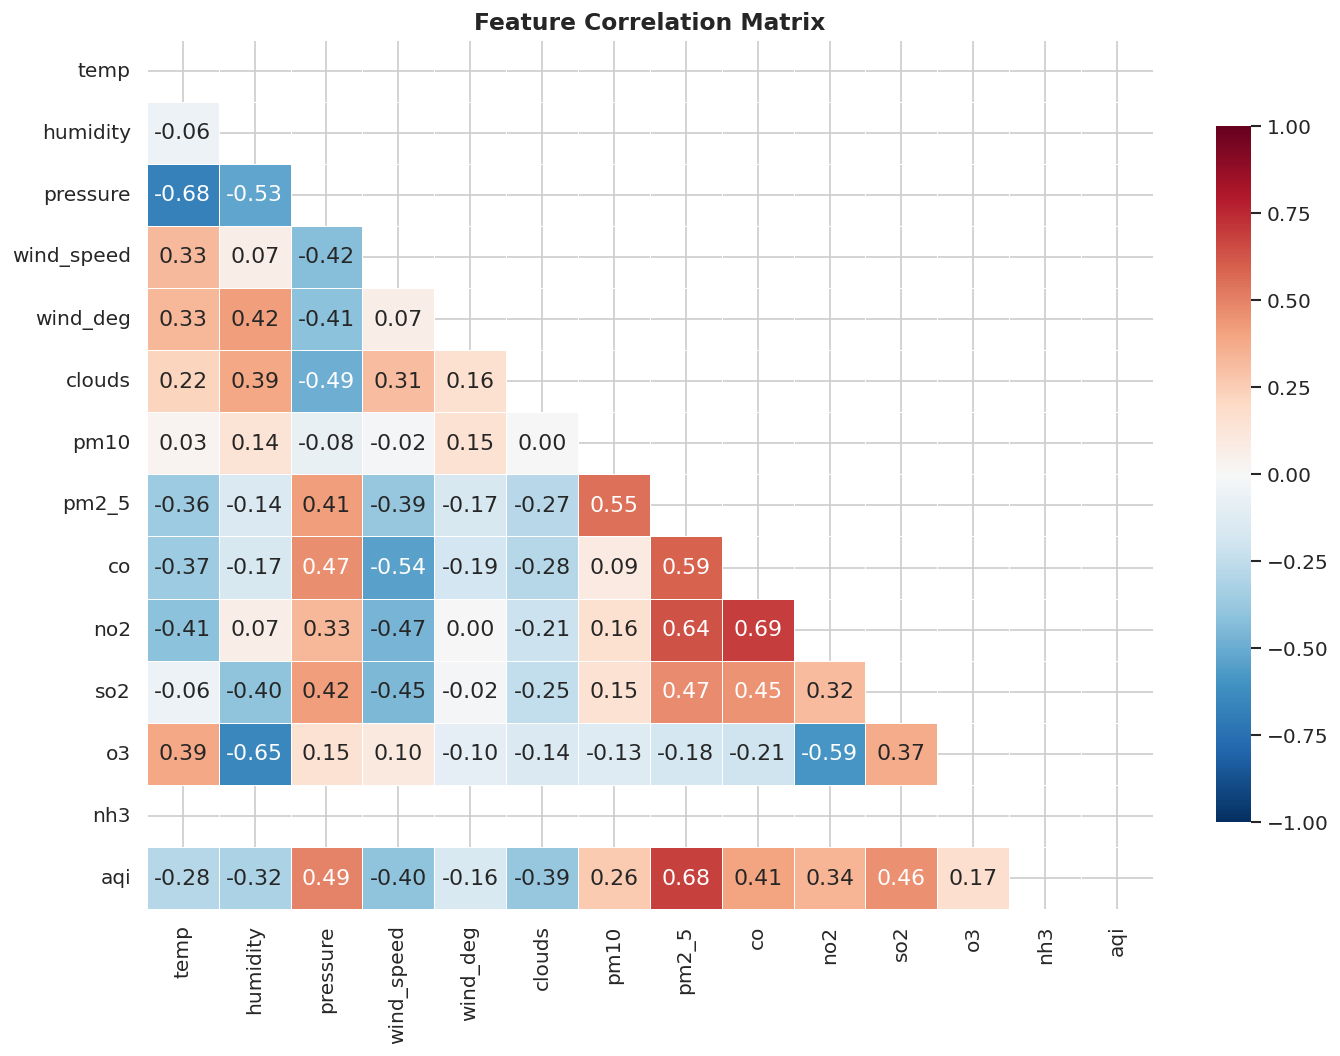


=== Correlation with AQI (sorted by |r|) ===
  pm2_5            r = +0.682
  pressure         r = +0.494
  so2              r = +0.459
  co               r = +0.406
  wind_speed       r = -0.404
  clouds           r = -0.386
  no2              r = +0.340
  humidity         r = -0.319
  temp             r = -0.282
  pm10             r = +0.262
  o3               r = +0.168
  wind_deg         r = -0.162
  nh3              r = +nan


In [19]:
numeric_cols = df.select_dtypes(include='number').columns.tolist()
if 'aqi_category' in df.columns:
    numeric_cols = [c for c in numeric_cols if c != 'aqi_category']

corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(12, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Matrix', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

# Top correlations with AQI
print('\n=== Correlation with AQI (sorted by |r|) ===')
aqi_corr = corr['aqi'].drop('aqi').abs().sort_values(ascending=False)
for feat, r in aqi_corr.items():
    sign = corr.loc[feat, 'aqi']
    print(f'  {feat:15s}  r = {sign:+.3f}')

### 4. Pollutant Distributions
Histograms with KDE for each pollutant variable.

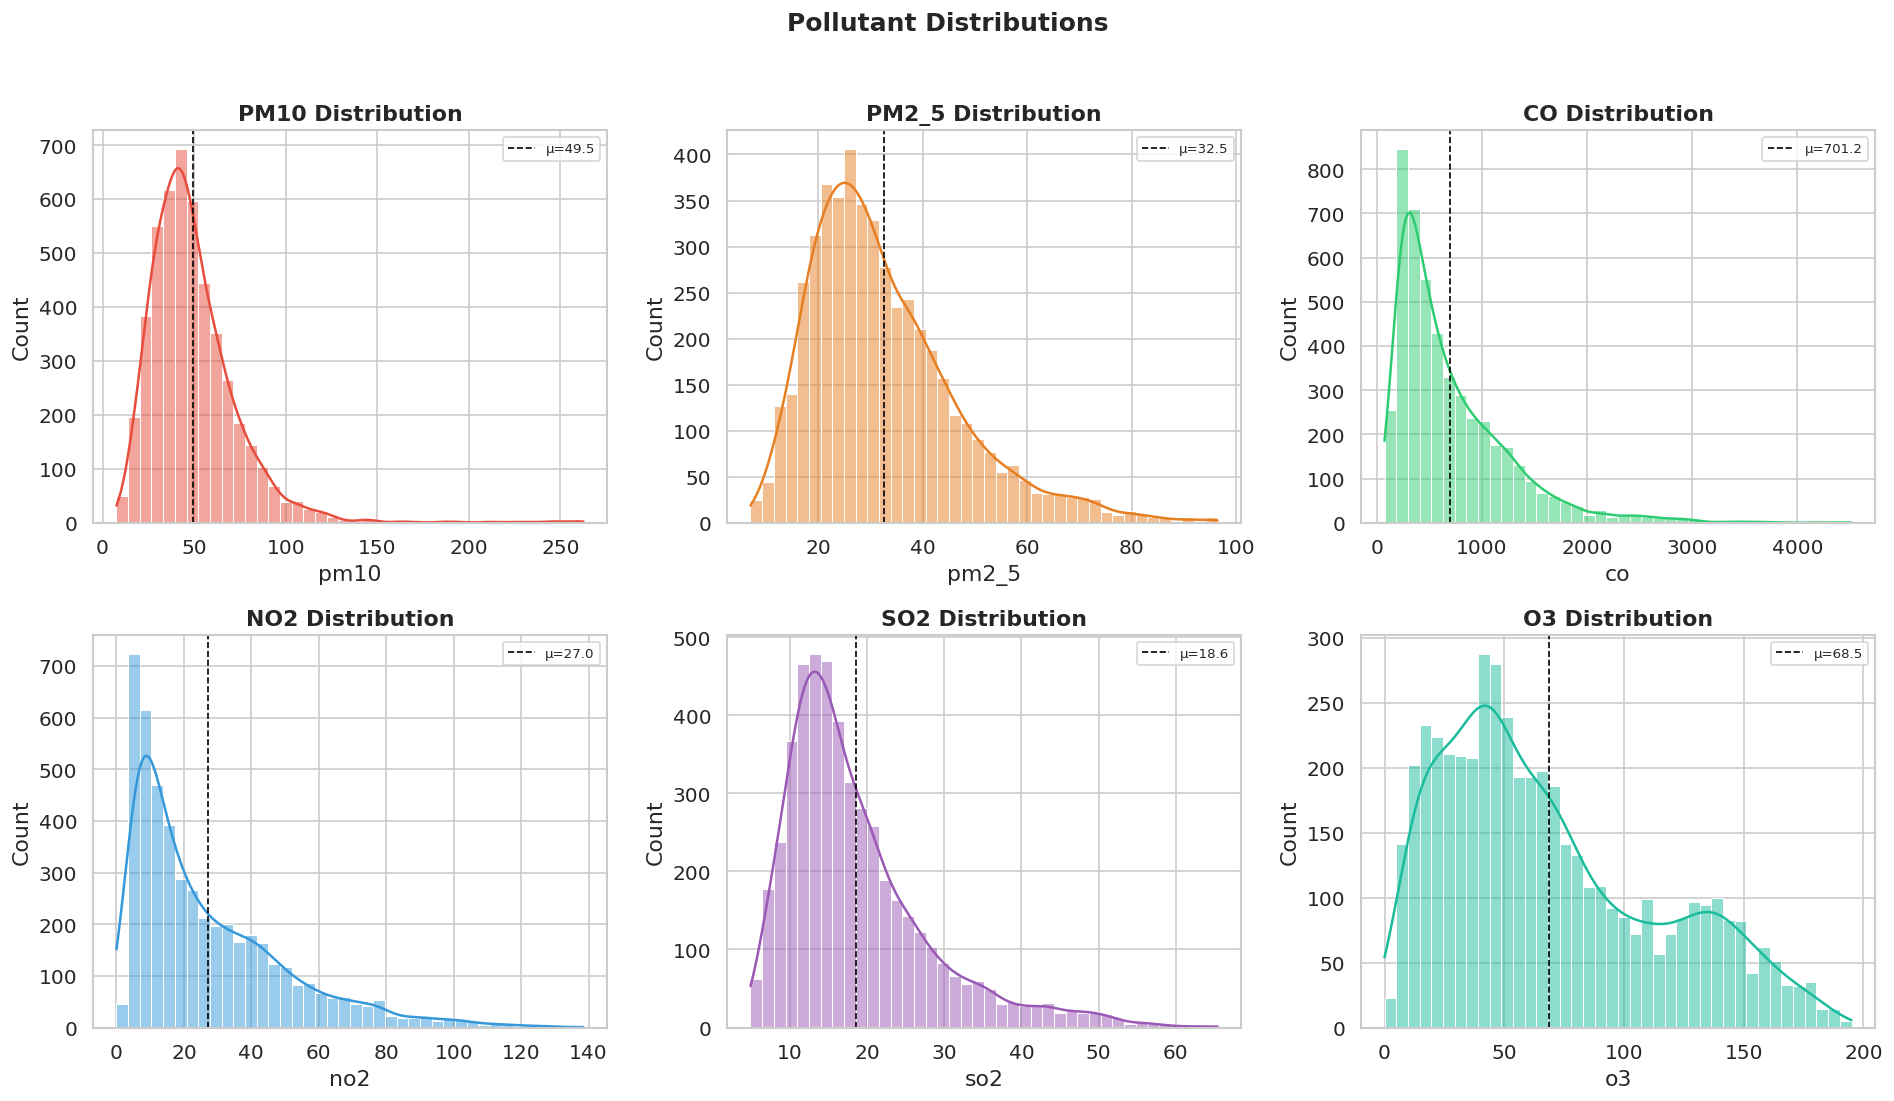

In [20]:
pollutants = ['pm10', 'pm2_5', 'co', 'no2', 'so2', 'o3']
colors = ['#e74c3c', '#e67e22', '#2ecc71', '#3498db', '#9b59b6', '#1abc9c']

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
for ax, col, c in zip(axes.flat, pollutants, colors):
    sns.histplot(df[col], bins=40, kde=True, color=c, ax=ax)
    ax.set_title(f'{col.upper()} Distribution', fontweight='bold')
    ax.axvline(df[col].mean(), color='black', ls='--', lw=1, label=f'μ={df[col].mean():.1f}')
    ax.legend(fontsize=8)

plt.suptitle('Pollutant Distributions', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 5. Pollutant Box Plots (Outlier Detection)
Compare spread and outliers across pollutants.

/tmp/ipython-input-339989023.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melt, x='Pollutant', y='Concentration', palette='Set2', ax=ax)


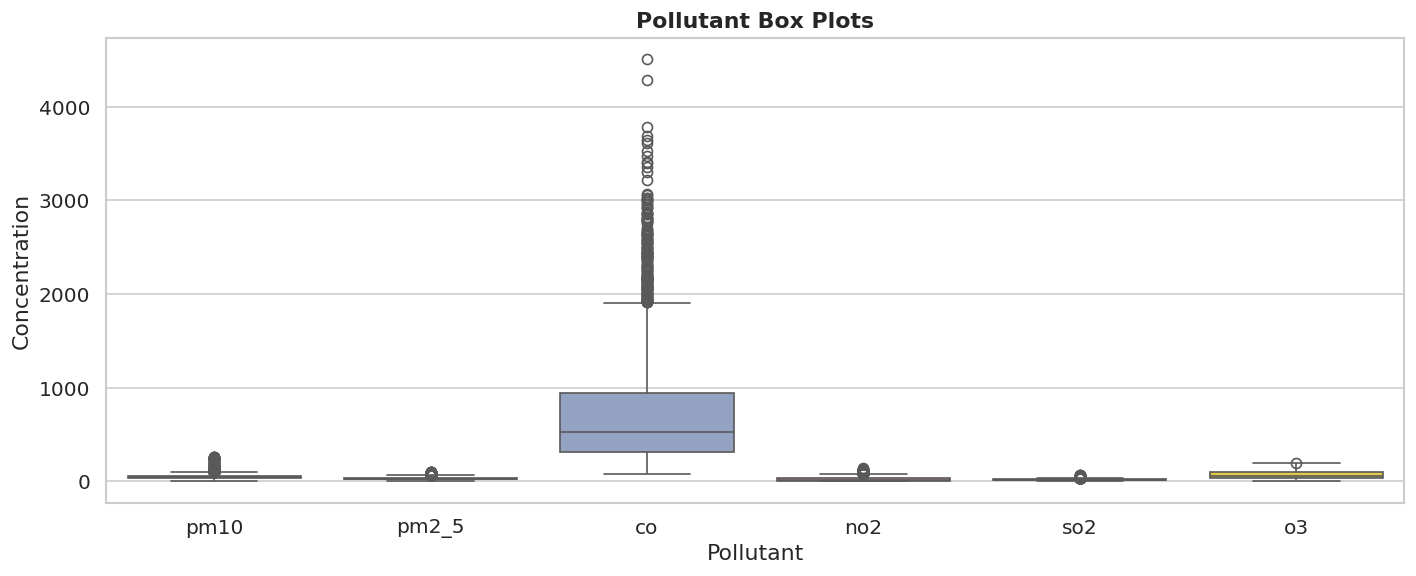

In [21]:
fig, ax = plt.subplots(figsize=(12, 5))
df_melt = df[pollutants].melt(var_name='Pollutant', value_name='Concentration')
sns.boxplot(data=df_melt, x='Pollutant', y='Concentration', palette='Set2', ax=ax)
ax.set_title('Pollutant Box Plots', fontweight='bold')
plt.tight_layout()
plt.show()

### 6. Scatter Plots — Pollutants vs AQI
How each pollutant relates to the overall US AQI.

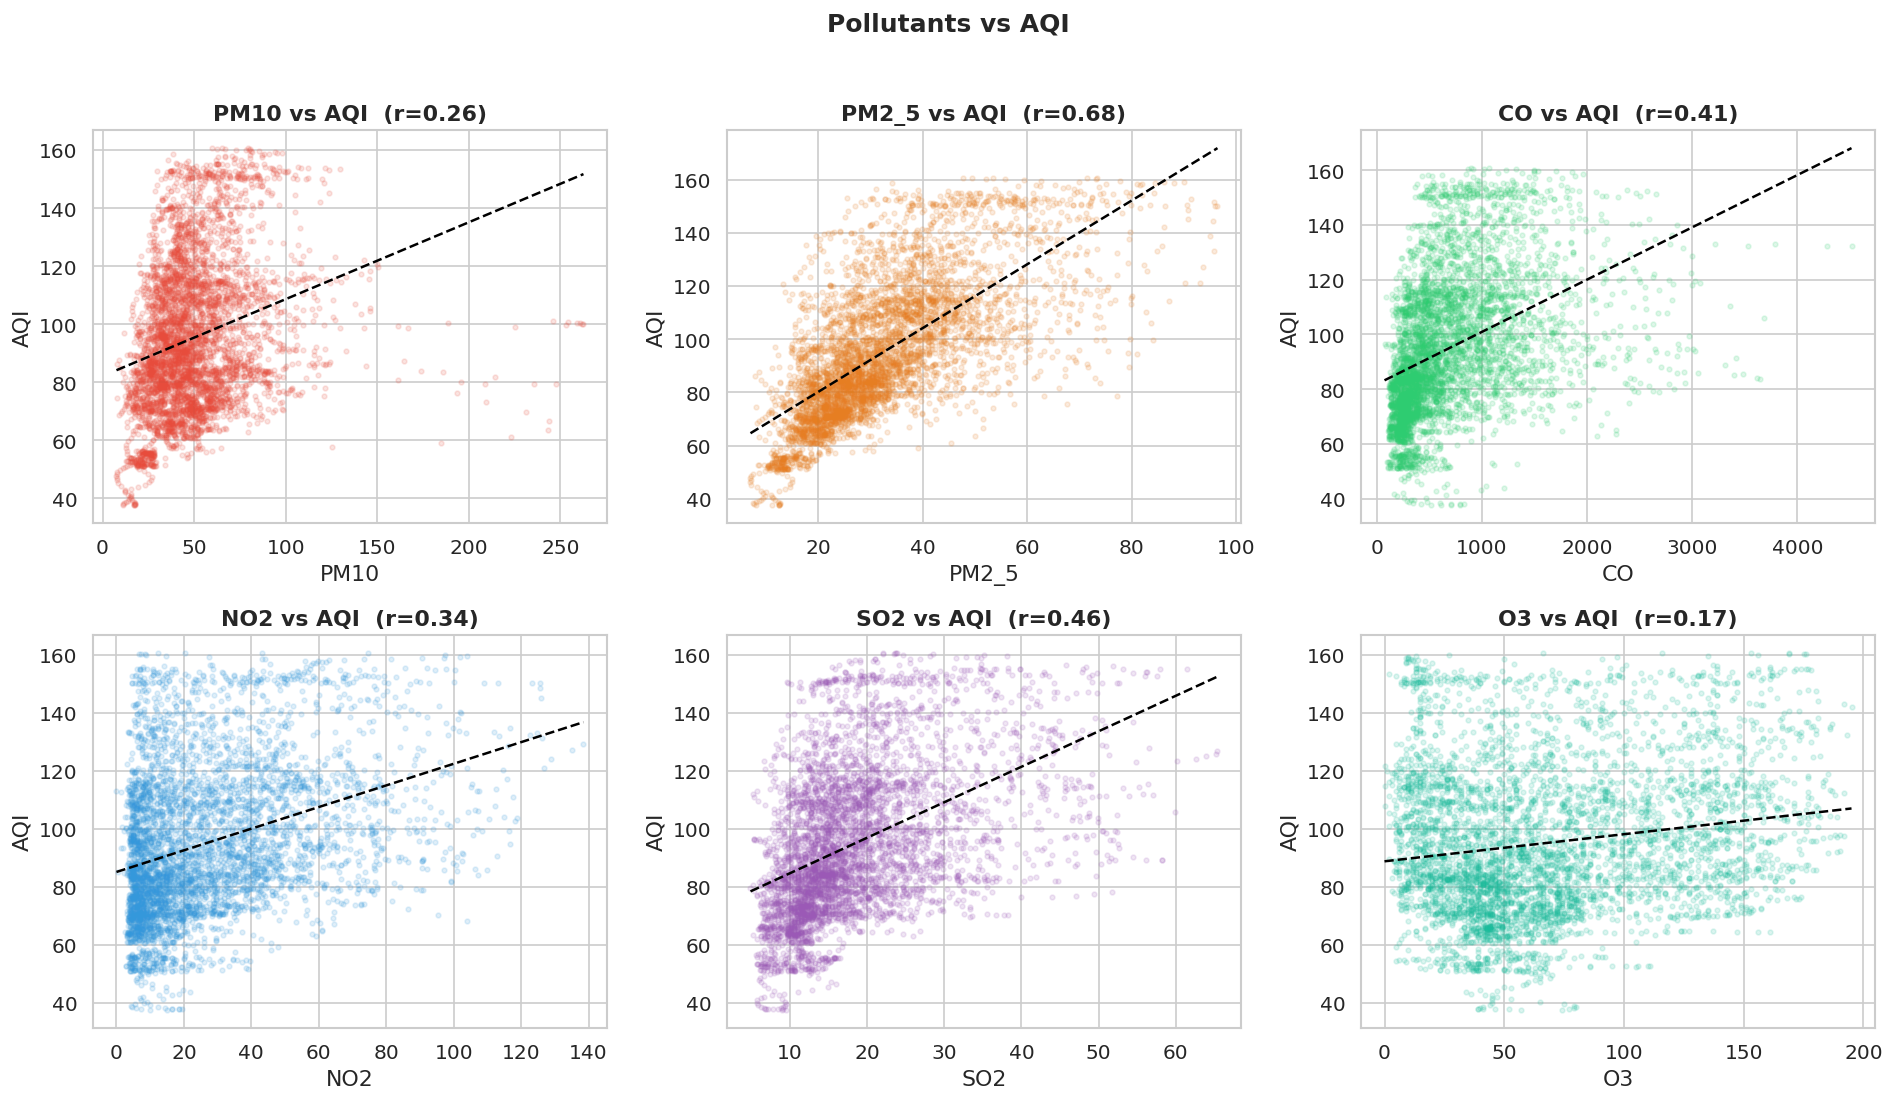

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
for ax, col, c in zip(axes.flat, pollutants, colors):
    ax.scatter(df[col], df['aqi'], alpha=0.15, s=8, color=c)
    # Trend line
    z = np.polyfit(df[col], df['aqi'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df[col].min(), df[col].max(), 100)
    ax.plot(x_line, p(x_line), '--', color='black', lw=1.5)
    r = df[col].corr(df['aqi'])
    ax.set_title(f'{col.upper()} vs AQI  (r={r:.2f})', fontweight='bold')
    ax.set_xlabel(col.upper())
    ax.set_ylabel('AQI')

plt.suptitle('Pollutants vs AQI', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 7. Weather Features vs AQI
Scatter plots of weather variables against AQI.

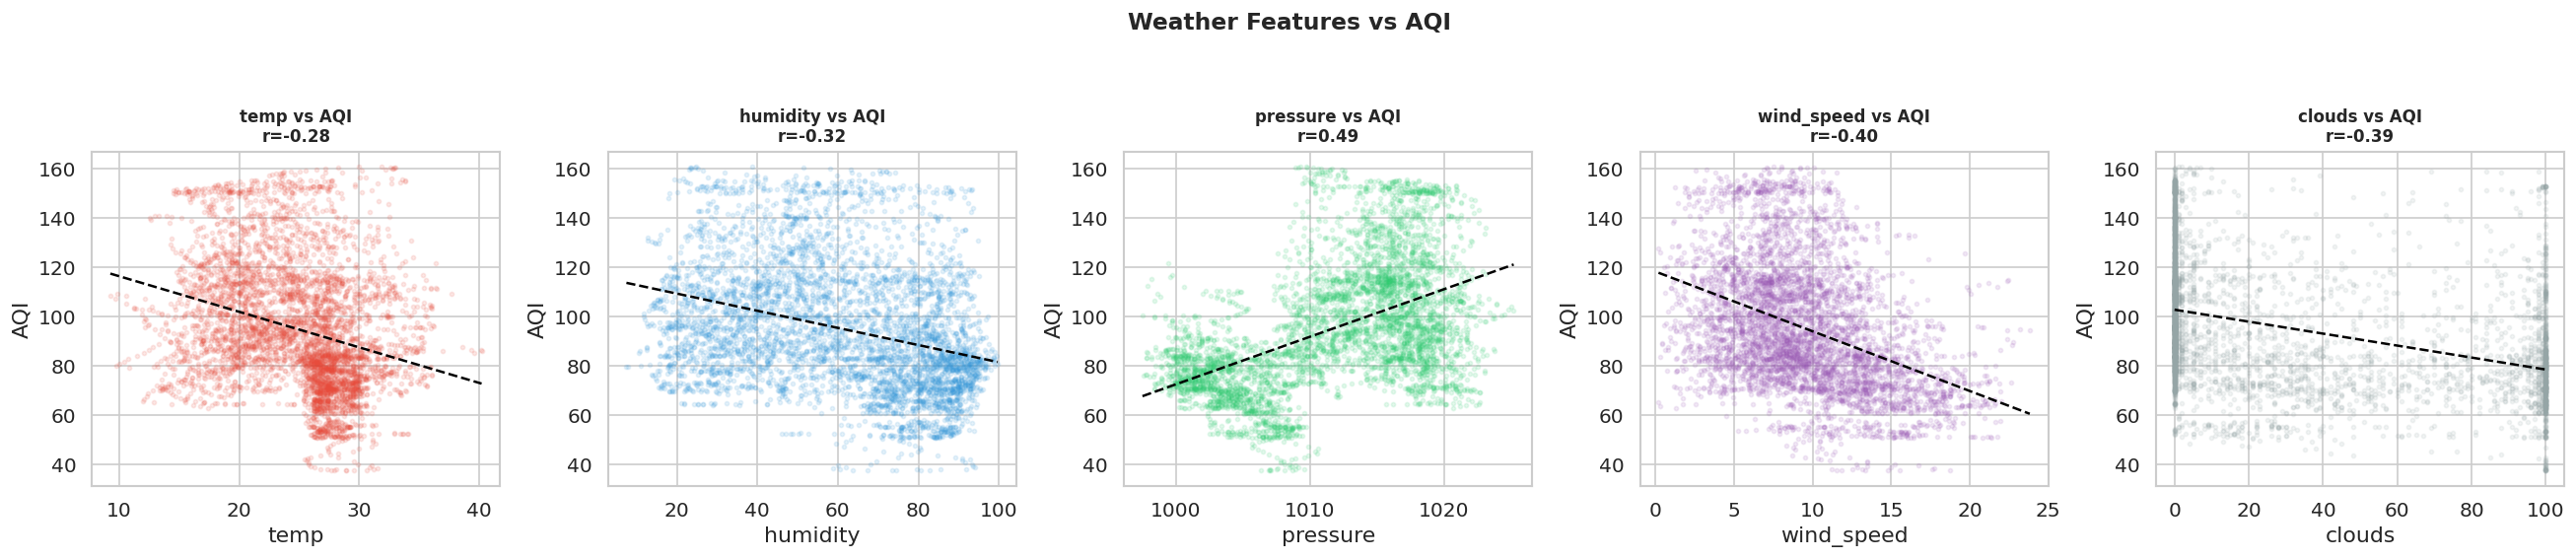

In [23]:
weather_feats = ['temp', 'humidity', 'pressure', 'wind_speed', 'clouds']
w_colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#95a5a6']

fig, axes = plt.subplots(1, 5, figsize=(22, 4.5))
for ax, col, c in zip(axes.flat, weather_feats, w_colors):
    ax.scatter(df[col], df['aqi'], alpha=0.12, s=6, color=c)
    z = np.polyfit(df[col], df['aqi'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df[col].min(), df[col].max(), 100)
    ax.plot(x_line, p(x_line), '--', color='black', lw=1.5)
    r = df[col].corr(df['aqi'])
    ax.set_title(f'{col} vs AQI\nr={r:.2f}', fontweight='bold', fontsize=10)
    ax.set_xlabel(col)
    ax.set_ylabel('AQI')

plt.suptitle('Weather Features vs AQI', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

### 8. Pair Plot — Key Features
Pair-wise scatter for the top correlated features with AQI.

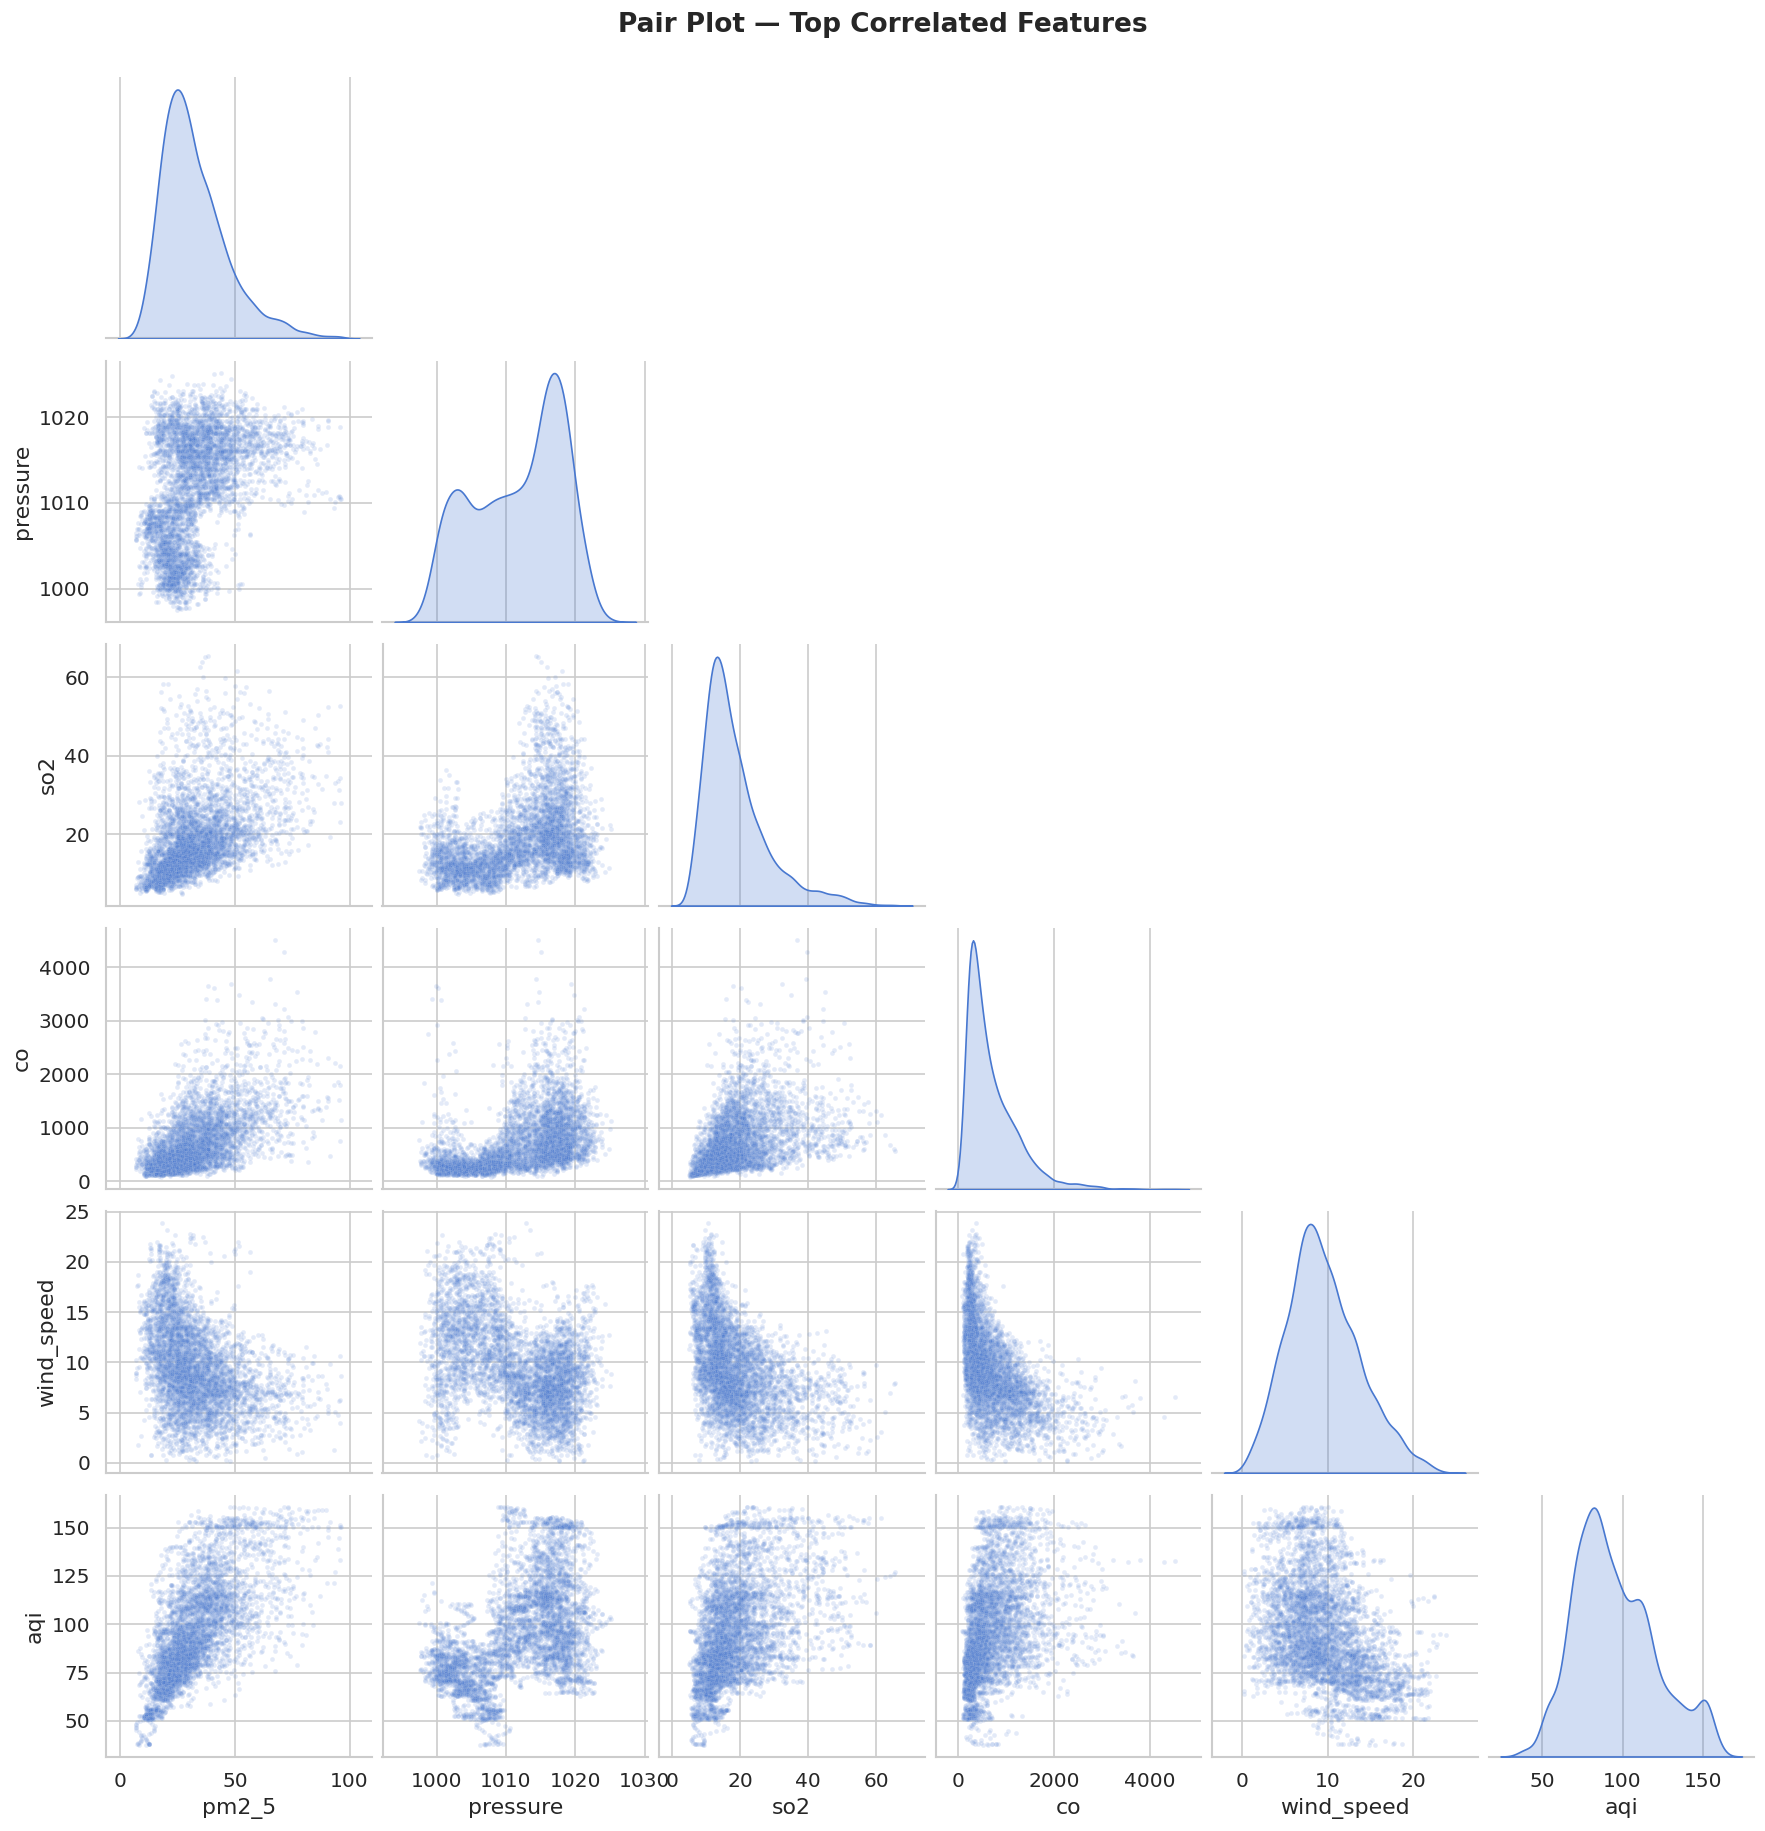

In [24]:
key_feats = ['pm2_5', 'pressure', 'so2', 'co', 'wind_speed', 'aqi']
g = sns.pairplot(df[key_feats], corner=True, diag_kind='kde',
                 plot_kws={'alpha': 0.15, 's': 8})
g.fig.suptitle('Pair Plot — Top Correlated Features', y=1.02, fontweight='bold')
plt.show()

### 9. AQI Time-Series & Temporal Patterns
Re-fetch datetime to explore hourly/daily patterns in AQI.

Fetching historical data from 2025-08-01 to 2026-02-17...
Weather data points: 4824
Weather DF Head:
                   datetime       temp   humidity     pressure  wind_speed  \
0 2025-08-01 00:00:00+00:00  26.549999  90.678726  1000.200012   10.134496   
1 2025-08-01 01:00:00+00:00  27.000000  91.792793   999.900024   10.985900   
2 2025-08-01 02:00:00+00:00  27.400000  88.604935  1000.799988   13.272482   
3 2025-08-01 03:00:00+00:00  28.549999  75.067810  1001.299988   14.169785   
4 2025-08-01 04:00:00+00:00  29.000000  73.134613  1001.599976   13.878689   

     wind_deg  clouds  
0  250.277634    95.0  
1  251.861816    75.0  
2  249.352936    23.0  
3  244.411530    47.0  
4  236.103790    99.0  
AQI DF Head:
                   datetime       pm10      pm2_5     co  no2   so2    o3  \
0 2025-08-01 00:00:00+00:00  45.799999  19.700001  174.0  8.4   8.7  45.0   
1 2025-08-01 01:00:00+00:00  45.200001  19.299999  217.0  9.0   9.4  46.0   
2 2025-08-01 02:00:00+00:00  51.000000  20

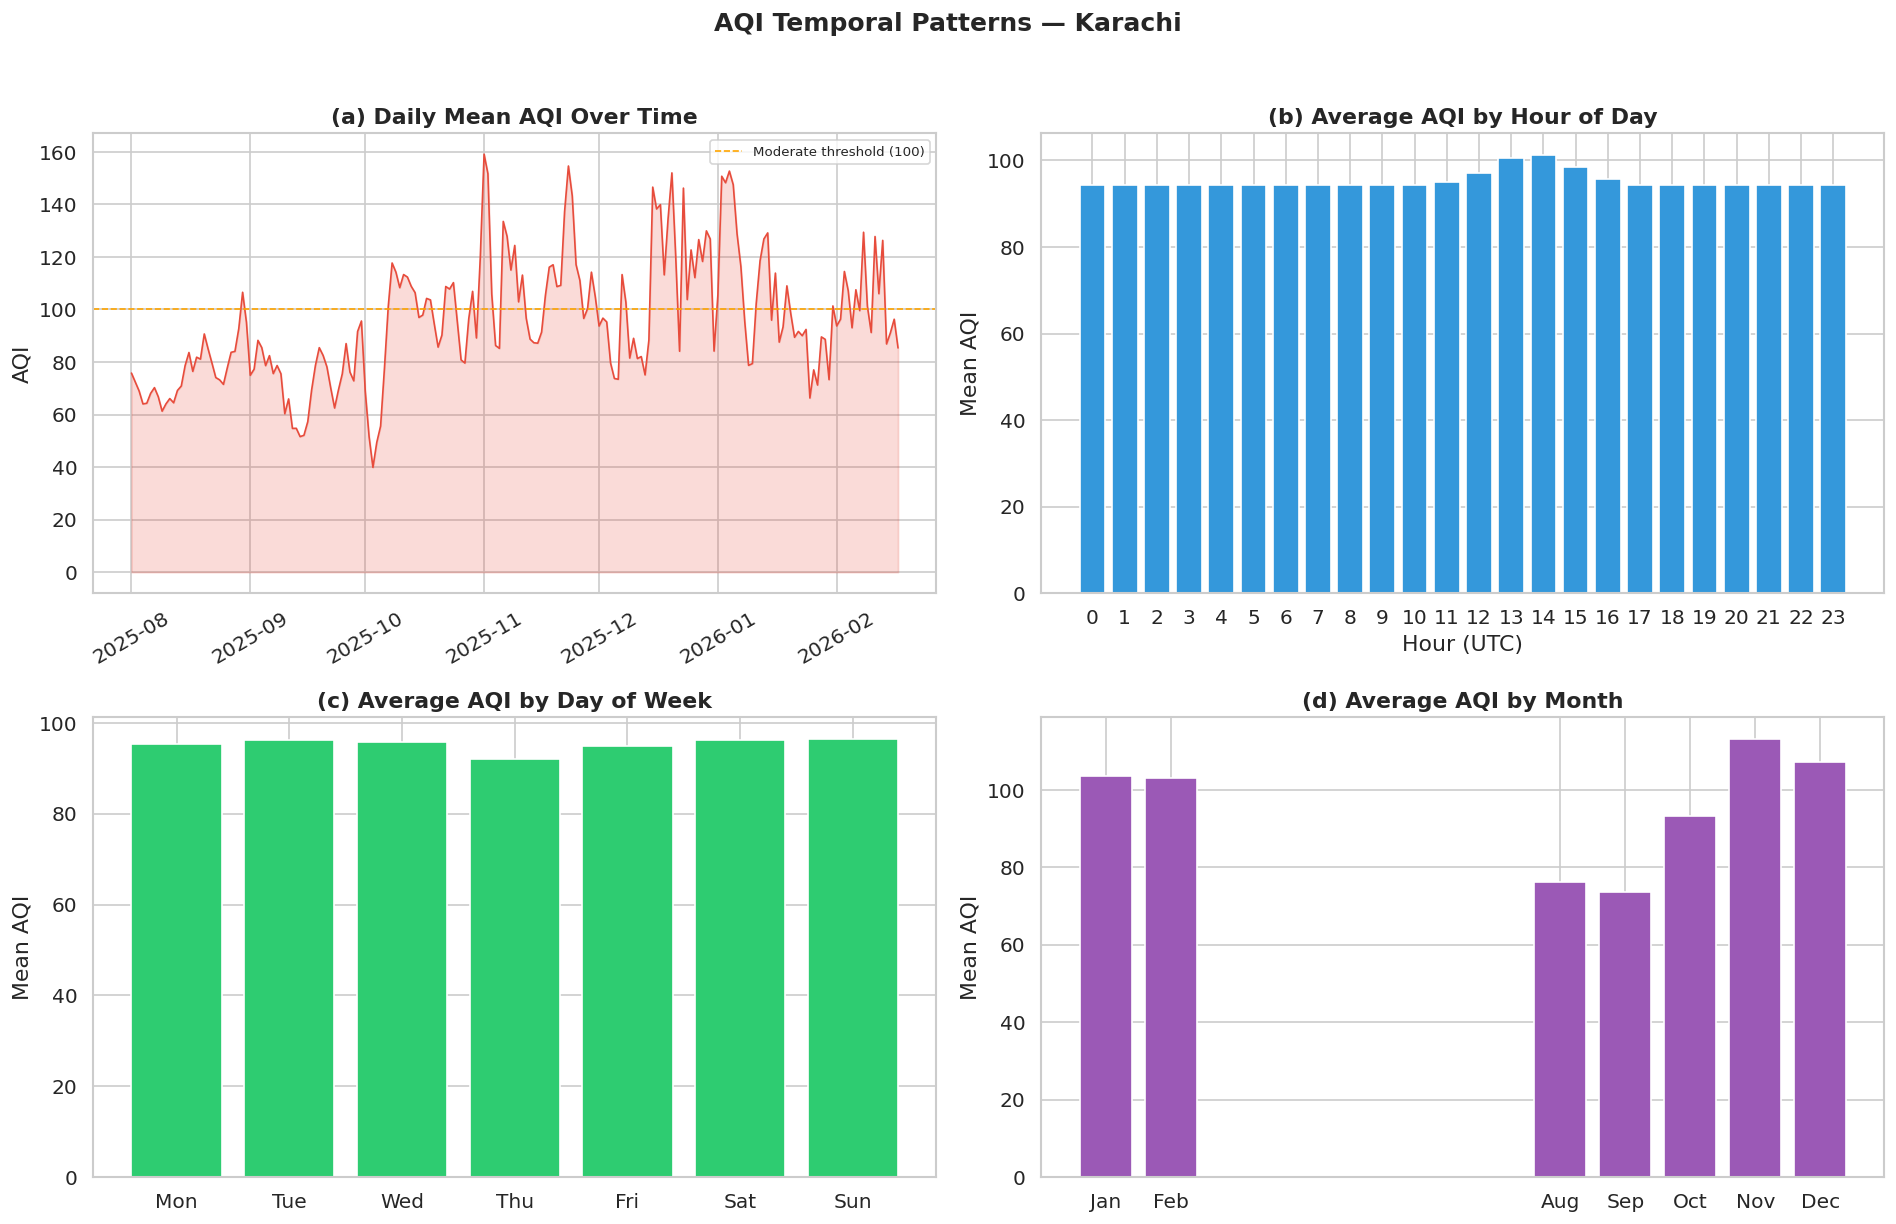

In [25]:
# Re-fetch data with datetime for temporal analysis
df_ts = fetch_historical_data("2025-08-01", datetime.now().strftime("%Y-%m-%d"))
df_ts['hour'] = df_ts['datetime'].dt.hour
df_ts['date'] = df_ts['datetime'].dt.date
df_ts['month'] = df_ts['datetime'].dt.month
df_ts['day_of_week'] = df_ts['datetime'].dt.dayofweek

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (a) Daily AQI time series
daily_aqi = df_ts.groupby('date')['aqi'].mean()
axes[0, 0].plot(daily_aqi.index, daily_aqi.values, color='#e74c3c', lw=1)
axes[0, 0].fill_between(daily_aqi.index, daily_aqi.values, alpha=0.2, color='#e74c3c')
axes[0, 0].axhline(100, color='orange', ls='--', lw=1, label='Moderate threshold (100)')
axes[0, 0].set_title('(a) Daily Mean AQI Over Time', fontweight='bold')
axes[0, 0].set_ylabel('AQI')
axes[0, 0].legend(fontsize=8)
axes[0, 0].tick_params(axis='x', rotation=30)

# (b) Average AQI by hour of day
hourly_aqi = df_ts.groupby('hour')['aqi'].mean()
axes[0, 1].bar(hourly_aqi.index, hourly_aqi.values, color='#3498db', edgecolor='white')
axes[0, 1].set_title('(b) Average AQI by Hour of Day', fontweight='bold')
axes[0, 1].set_xlabel('Hour (UTC)')
axes[0, 1].set_ylabel('Mean AQI')
axes[0, 1].set_xticks(range(0, 24))

# (c) Average AQI by day of week
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_aqi = df_ts.groupby('day_of_week')['aqi'].mean()
axes[1, 0].bar(dow_aqi.index, dow_aqi.values, color='#2ecc71', edgecolor='white')
axes[1, 0].set_title('(c) Average AQI by Day of Week', fontweight='bold')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(dow_labels)
axes[1, 0].set_ylabel('Mean AQI')

# (d) Average AQI by month
month_aqi = df_ts.groupby('month')['aqi'].mean()
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
axes[1, 1].bar(month_aqi.index, month_aqi.values, color='#9b59b6', edgecolor='white')
axes[1, 1].set_title('(d) Average AQI by Month', fontweight='bold')
axes[1, 1].set_xticks(month_aqi.index)
axes[1, 1].set_xticklabels([month_labels[m-1] for m in month_aqi.index])
axes[1, 1].set_ylabel('Mean AQI')

plt.suptitle('AQI Temporal Patterns — Karachi', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 10. AQI Heatmap — Hour of Day × Day of Week
Identifies when AQI tends to be worst.

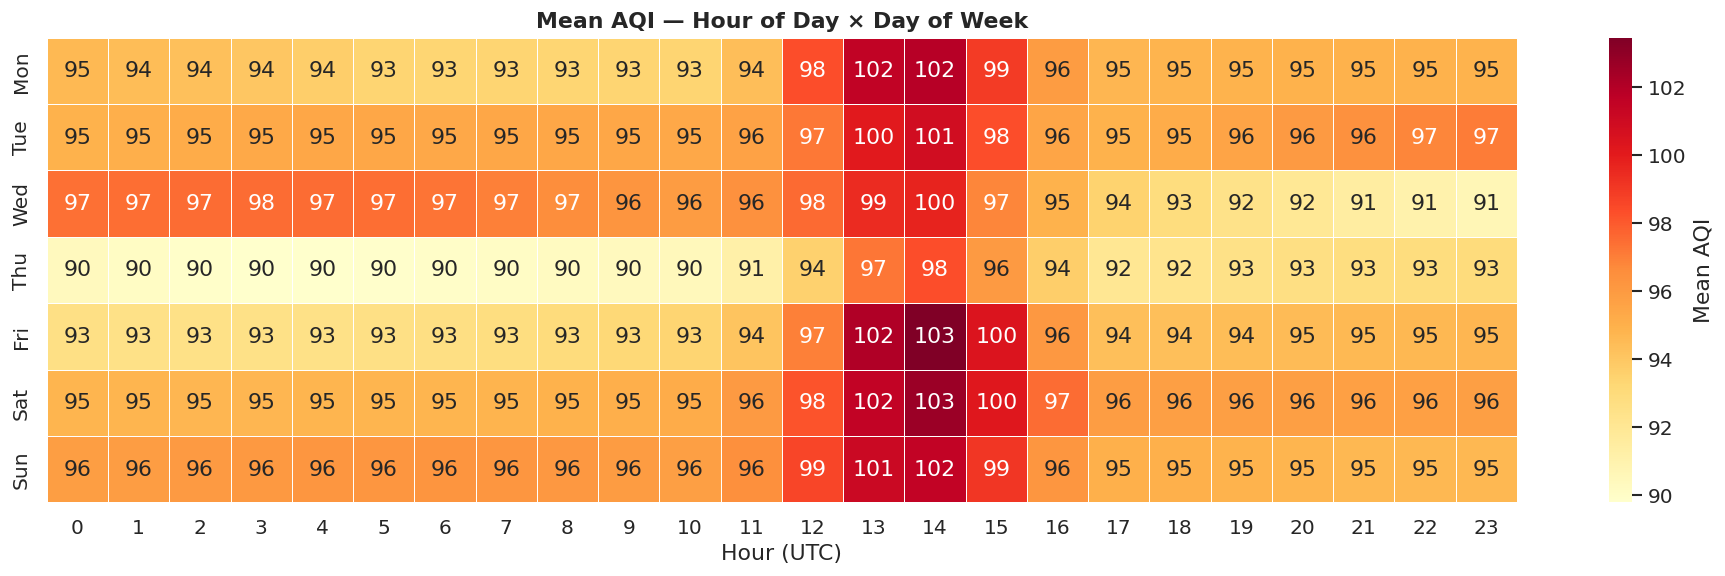

In [26]:
pivot = df_ts.pivot_table(values='aqi', index='day_of_week', columns='hour', aggfunc='mean')
pivot.index = dow_labels

fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.0f', linewidths=0.3,
            ax=ax, cbar_kws={'label': 'Mean AQI'})
ax.set_title('Mean AQI — Hour of Day × Day of Week', fontweight='bold')
ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

### 11. Rolling Averages — AQI & PM2.5
Smooth out hourly noise with 24h and 7-day moving averages.

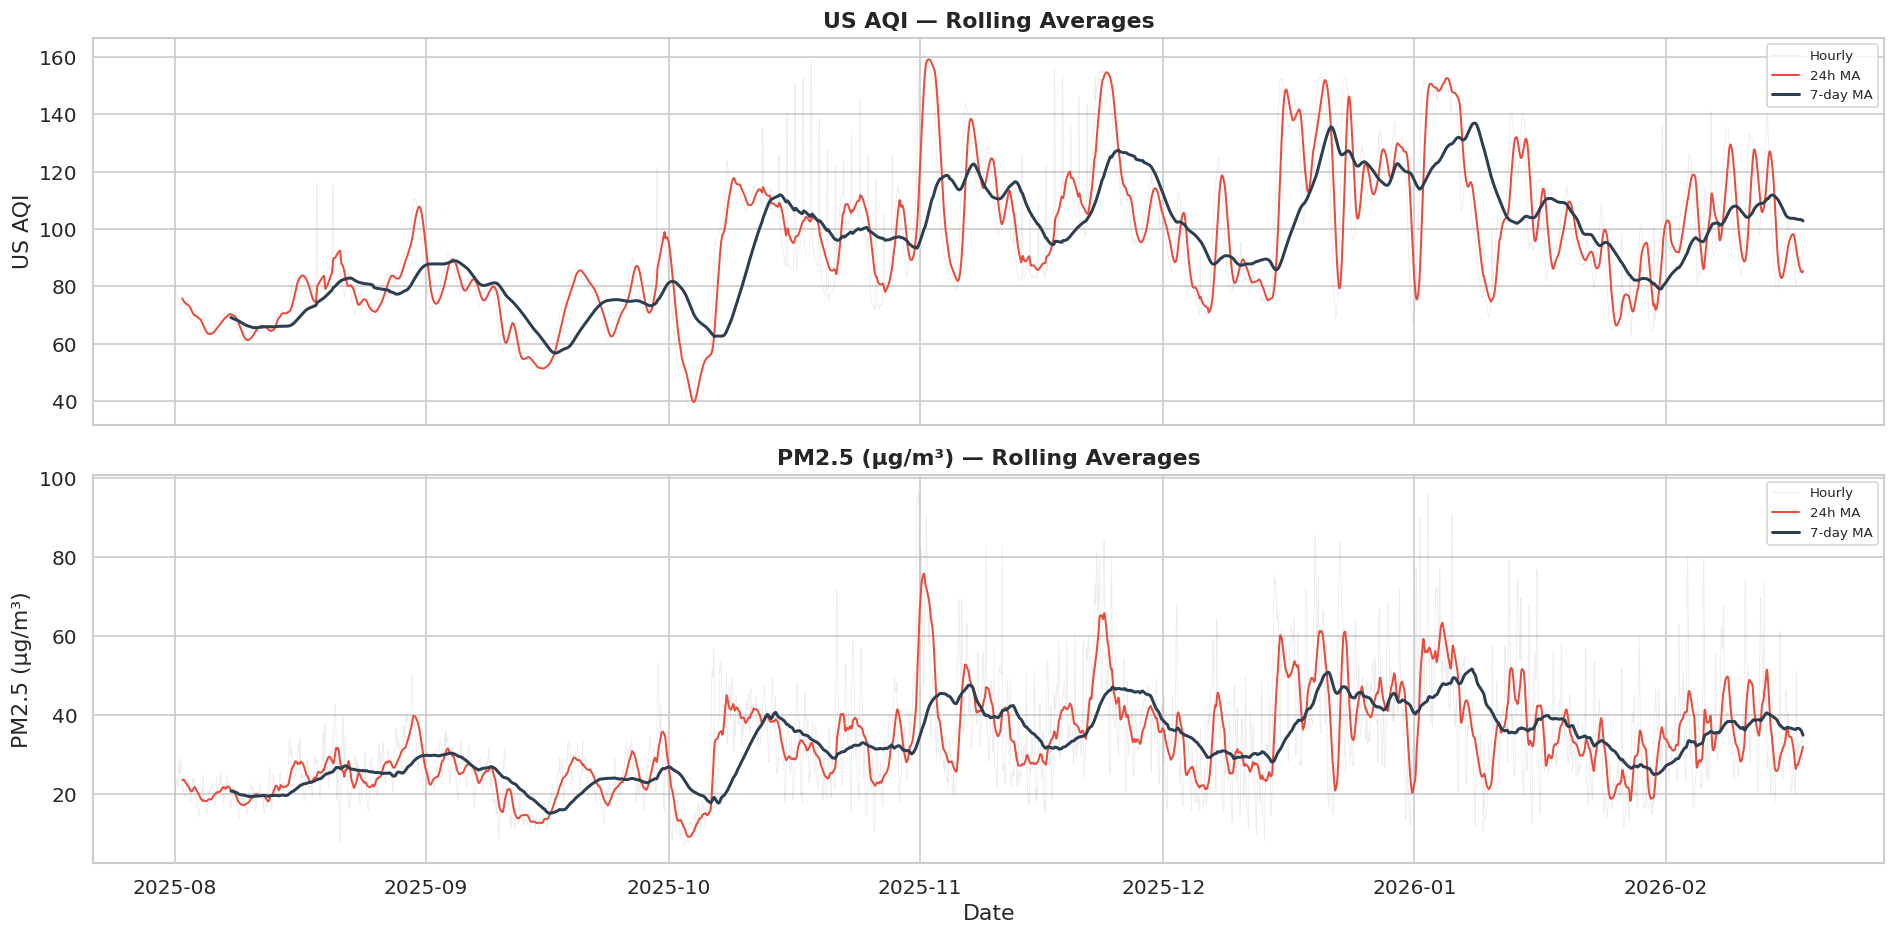

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

for ax, col, label in zip(axes, ['aqi', 'pm2_5'], ['US AQI', 'PM2.5 (µg/m³)']):
    ax.plot(df_ts['datetime'], df_ts[col], alpha=0.15, color='grey', lw=0.5, label='Hourly')
    ax.plot(df_ts['datetime'], df_ts[col].rolling(24).mean(), color='#e74c3c', lw=1.2, label='24h MA')
    ax.plot(df_ts['datetime'], df_ts[col].rolling(24*7).mean(), color='#2c3e50', lw=1.8, label='7-day MA')
    ax.set_ylabel(label)
    ax.legend(fontsize=8)
    ax.set_title(f'{label} — Rolling Averages', fontweight='bold')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

### 12. Summary Statistics Table
Comprehensive stats for all numeric features.

In [28]:
stats_df = df[numeric_cols].describe().T
stats_df['skew'] = df[numeric_cols].skew()
stats_df['kurtosis'] = df[numeric_cols].kurtosis()
stats_df['iqr'] = stats_df['75%'] - stats_df['25%']
stats_df = stats_df.round(2)
stats_df

count     mean     std     min      25%      50%      75%  \
temp        4824.0    24.69    4.93    9.25    20.85    25.85    28.00   
humidity    4824.0    60.67   23.09    7.47    41.19    63.45    81.47   
pressure    4824.0  1011.74    6.46  997.50  1006.20  1013.00  1017.20   
wind_speed  4824.0     9.53    4.21    0.18     6.66     9.01    12.22   
wind_deg    4824.0   189.45  112.07    1.15    57.99   235.28   271.27   
clouds      4824.0    31.40   40.14    0.00     0.00     5.00    71.00   
pm10        4824.0    49.48   24.92    7.60    33.40    45.10    60.10   
pm2_5       4824.0    32.51   14.33    7.00    22.20    29.50    39.70   
co          4824.0   701.17  535.19   74.00   309.00   530.00   946.50   
no2         4824.0    27.01   22.96    0.00     9.20    19.30    38.80   
so2         4824.0    18.60    9.45    4.90    12.10    16.00    22.40   
o3          4824.0    68.51   45.22    0.00    34.00    57.00    98.00   
nh3         4824.0     0.00    0.00    0.00     0.00     0.00     0.00   
aqi         4824.0    95.24   25.21   37.69    76.78    90.87   111.52   

                max  skew  kurtosis     iqr  
temp          40.20 -0.30     -0.38    7.15  
humidity      99.69 -0.28     -1.15   40.28  
pressure    1025.20 -0.34     -1.10   11.00  
wind_speed    23.83  0.46     -0.06    5.56  
wind_deg     360.00 -0.36     -1.38  213.28  
clouds       100.00  0.83     -1.06   71.00  
pm10         262.60  2.48     13.60   26.70  
pm2_5         96.40  1.14      1.57   17.50  
co          4515.00  1.80      4.47  637.50  
no2          138.50  1.42      1.94   29.60  
so2           65.40  1.50      2.54   10.30  
o3           195.00  0.70     -0.47   64.00  
nh3            0.00  0.00      0.00    0.00  
aqi          160.70  0.53     -0.25   34.73

### Cleanup
Drop the helper column used for category labeling.

In [29]:
df = df.drop(columns=['aqi_category'], errors='ignore')
print(f'Final DataFrame shape: {df.shape}')
print('Columns:', list(df.columns))

Final DataFrame shape: (4824, 15)
Columns: ['datetime', 'temp', 'humidity', 'pressure', 'wind_speed', 'wind_deg', 'clouds', 'pm10', 'pm2_5', 'co', 'no2', 'so2', 'o3', 'nh3', 'aqi']
